In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [2]:
circ = zx.cliffords(3, 10)
print(circ)

Graph(32 vertices, 32 edges)


In [3]:
zx.clifford_simp(circ)
zx.drawing.pack_circuit_nf(circ,'gslc')
#zx.spider_simp(circ)

spider_simp
5. 2. 1. 1. 
finished in 5 iterations
spider_simp
2. 
finished in 2 iterations
pivot_simp
3. 1. 
finished in 3 iterations
lcomp_simp
2. 1. 1. 
finished in 4 iterations
pivot_simp

finished in 1 iterations
id_simp

finished in 1 iterations


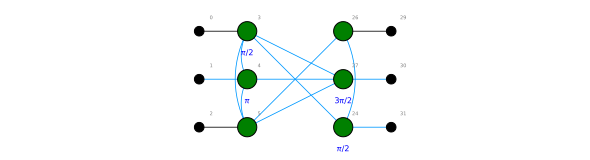

In [4]:
zx.draw(circ,labels=True)

In [15]:
max(circ.row(v) for v in circ.vertices())

4

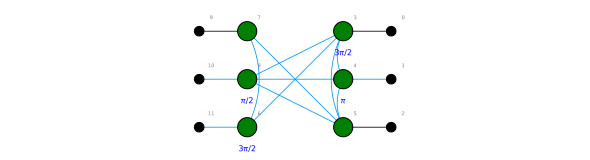

In [12]:
zx.draw(circ.copy(adjoint=True),labels=True)

In [16]:
from pyzx.extract import bi_adj
left = []
right = []
for v in circ.vertices():
    if circ.row(v) == 1:
        left.append(v)
    if circ.row(v) == 3:
        right.append(v)

left.sort(key=lambda v: circ.row(v))
right.sort(key=lambda v: circ.row(v))
#left = [5,6,7,8,9]
#right = [48,51,44,53,54]
qubits = len(left)
m = bi_adj(circ,left,right)
if m.rank() != qubits: print("Error!")
m

[ 1  0  0 ]
[ 0  0  1 ]
[ 1  1  1 ]

In [6]:
class CNOTMaker(object):
    def __init__(self, qubits):
        self.qubits = qubits
        self.g = zx.Graph()
        self.qs = list(range(qubits))  # tracks qubit indices of vertices
        self.v = 0                     # next vertex to add
        self.r = 0                     # current row
        
        for i in range(qubits):
            self.add_node(i, 0, False)
            self.g.set_vdata(self.v, 'i', True)
            self.v += 1
        self.r += 1
    
    def finish(self):
        for i in range(self.qubits):
            self.add_node(i, 0)
            self.g.set_vdata(self.v-1, 'o', True)
        self.r += 1
    
    def add_node(self, q, t, update_index=True):
        self.g.add_vertex(t,q,self.r)
        if update_index:
            self.g.add_edge((self.qs[q],self.v))
            self.qs[q] = self.v
            self.v += 1
    
    def row_swap(self, r1, r2):
        print("row_swap", r1,r2)
        self.add_node(r1, 1)
        self.add_node(r2, 1)
        self.r += 1
        self.add_node(r1, 1, False)
        self.g.add_edge((self.qs[r2],self.v))
        self.v += 1
        self.add_node(r2, 1, False)
        self.g.add_edge((self.qs[r1],self.v))
        self.qs[r1] = self.v - 1
        self.qs[r2] = self.v
        self.v += 1
        self.r += 1
    
    def row_add(self, r1, r2):
        print("row_add", r1,r2)
        self.add_node(r1, 2)
        self.add_node(r2, 1)
        self.g.add_edge((self.qs[r1],self.qs[r2]))
        self.r += 1

c = CNOTMaker(qubits)
m.gauss(full_reduce=True,x=c)
c.finish()

row_add 0 2
row_swap 2 1
row_add 2 1


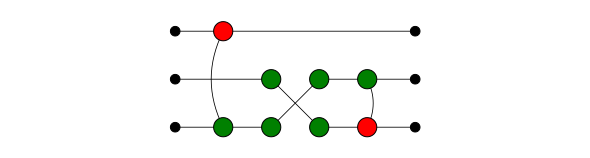

In [17]:
zx.draw(c.g)

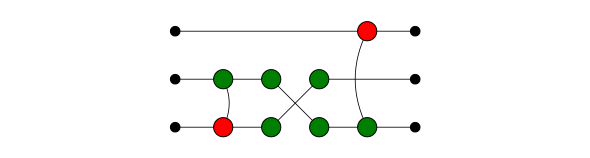

In [11]:
zx.draw(c.g.copy(adjoint=True))

spider_simp
1. 1. 
finished in 3 iterations
spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
id_simp

finished in 1 iterations


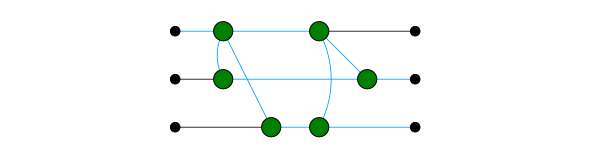

In [139]:
zx.clifford_simp(c.g)
zx.draw(c.g)

In [97]:
connections = {i: set() for i in range(qubits)}
connectionsr= {j: set() for j in range(qubits)}

for i in range(qubits):
        for j in range(qubits):
            if m.data[j][i]: 
                connections[i].add(j)
                connectionsr[j].add(i)

def find_targets(conn, connr, target={}):
    target = target.copy()
    qubits = len(conn)
    claimedr = set(target.values())
    claimed = set(target.keys())
    
    while True: #First determine which qubit should go to which other qubit, before we start adding cnots.
        min_index = -1
        min_options = set(range(1000))
        for i in range(qubits):
            if i in claimed: continue
            s = conn[i] - claimedr
            for i2 in s.copy(): # Go trough the possible options
                for j1 in (connr[i2] - claimed): 
                    if j1 != i and j1 in target and i in connr[target[j1]]: # i connected to j2
                        #This is not allowed
                        print("not allowed1:", i, i2)
                        s.remove(i2)
            if len(s) == 0: return None # No possible options, start backtracking
            if len(s) == 1:
                j = s.pop()
                print("forced1", i,j)
                target[i] = j
                claimed.add(i)
                claimedr.add(j)
                break
            should_break = False
            for i2 in s:
                t = connr[i2] - claimed
                for i1 in t.copy():
                    for j1 in connr[i2]:
                        if j1 != i1 and j1 in target and i1 in connr[target[j1]]: 
                            print("not allowed2:", i1, j1)
                            t.remove(i1)
                if len(t) == 0: return None
                if len(t) == 1: # we must connect them together
                    i1 = t.pop()
                    print("forced2", i1,i2)
                    target[i1] = i2
                    claimed.add(i1)
                    claimedr.add(i2)
                    should_break = True
                    break
            if should_break: break
            if len(s) < len(min_options):
                min_index = i
                min_options = s
        else: # No forced decisions
            if not (conn.keys() - claimed): # we are done
                return target
            if min_index == -1: raise ValueError("This shouldn't happen ever")
            # Start depth-first search
            tgt = target.copy()
            print("backtracking on", min_index)
            for i2 in min_options:
                print("trying option", i2)
                tgt[min_index] = i2
                r = find_targets(conn, connr, tgt)
                if r: return r
            return None
            
            
            
                        
                
#         for v in unclaimed:
#             if v in connections[v]: # We can make a 'straight' connection, so do so
#                 print("straight", v)
#                 target[v] = v
#                 unclaimed.remove(v)
#                 break

target = find_targets(connections, connectionsr)
target

forced2 1 2
forced1 3 4
backtracking on 0
trying option 0
not allowed2: 2 0
trying option 1
not allowed2: 2 0
forced2 4 0
forced1 2 3


{0: 1, 1: 2, 2: 3, 3: 4, 4: 0}

In [102]:
cnots = {i: set() for i in range(qubits)}

for i in range(qubits):
    for j in connections[i]:
        if target[i] == j: continue
        cnots[i].add(j)

for i, tgts in cnots.items():
    for j in tgts:
        #if j <= i: continue
        if i in cnots[j]: print("Conflict: ", i,j)

print(cnots)


Conflict:  0 0
Conflict:  1 1
Conflict:  4 4
{0: {0}, 1: {0, 1, 3}, 2: {0, 1}, 3: set(), 4: {3, 4}}


In [83]:
a = set([1,2,3])
b= set([3,4,5])
c = {1:4, 2:5}
for i in a.copy():
    a.remove(i)
a

set()